<a href="https://colab.research.google.com/github/matthew-lyr/other_stuffs/blob/main/hw4_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

本次作業是要讓同學接觸 NLP 當中一個簡單的 task —— 語句分類（文本分類）

給定一個語句，判斷他有沒有惡意（負面標 1，正面標 0）

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# path_prefix = 'drive/My Drive/Colab Notebooks/hw4 - Recurrent Neural Network'
path_prefix = './'

### Download Dataset
有三個檔案，分別是 training_label.txt、training_nolabel.txt、testing_data.txt

- training_label.txt：有 label 的 training data（句子配上 0 or 1，+++$+++ 只是分隔符號，不要理它）
    - e.g., 1 +++$+++ are wtf ... awww thanks !

- training_nolabel.txt：沒有 label 的 training data（只有句子），用來做 semi-supervised learning
    - ex: hates being this burnt !! ouch

- testing_data.txt：你要判斷 testing data 裡面的句子是 0 or 1

    >id,text

    >0,my dog ate our dinner . no , seriously ... he ate it .

    >1,omg last day sooon n of primary noooooo x im gona be swimming out of school wif the amount of tears am gona cry

    >2,stupid boys .. they ' re so .. stupid !

In [2]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1dPHIl8ZnfDz_fxNd2ZeBYedTat2lfxcO' -O 'drive/My Drive/Colab Notebooks/hw8-RNN/data/training_label.txt'
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1x1rJOX_ETqnOZjdMAbEE2pqIjRNa8xcc' -O 'drive/My Drive/Colab Notebooks/hw8-RNN/data/training_nolabel.txt'
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=16CtnQwSDCob9xmm6EdHHR7PNFNiOrQ30' -O 'drive/My Drive/Colab Notebooks/hw8-RNN/data/testing_data.txt'

!gdown --id '1lz0Wtwxsh5YCPdqQ3E3l_nbfJT1N13V8' --output data.zip
!unzip data.zip
!ls

Downloading...
From: https://drive.google.com/uc?id=1lz0Wtwxsh5YCPdqQ3E3l_nbfJT1N13V8
To: /content/data.zip
45.1MB [00:00, 143MB/s] 
Archive:  data.zip
  inflating: training_label.txt      
  inflating: testing_data.txt        
  inflating: training_nolabel.txt    
data.zip     testing_data.txt	 training_nolabel.txt
sample_data  training_label.txt


In [3]:
# this is for filtering the warnings
import warnings
warnings.filterwarnings('ignore')

### Utils

In [4]:
# 什么是torch.eq
# utils.py
# 這個 block 用來先定義一些等等常用到的函式
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F

def load_training_data(path='training_label.txt'):
    # 把 training 時需要的 data 讀進來
    # 如果是 'training_label.txt'，需要讀取 label，如果是 'training_nolabel.txt'，不需要讀取 label
    if 'training_label' in path:
        with open(path, 'r') as f:
            lines = f.readlines()
            lines = [line.strip('\n').split(' ') for line in lines]
        x = [line[2:] for line in lines]
        y = [line[0] for line in lines]
        return x, y
    else:
        with open(path, 'r') as f:
            lines = f.readlines()
            x = [line.strip('\n').split(' ') for line in lines]
        return x

def load_testing_data(path='testing_data'):
    # 把 testing 時需要的 data 讀進來
    with open(path, 'r') as f:
        lines = f.readlines()
        X = ["".join(line.strip('\n').split(",")[1:]).strip() for line in lines[1:]]
        X = [sen.split(' ') for sen in X]
    return X

def evaluation(outputs, labels):
    # outputs => probability (float)
    # labels => labels
    outputs[outputs>=0.5] = 1 # 大於等於 0.5 為正面
    outputs[outputs<0.5] = 0 # 小於 0.5 為負面
    correct = torch.sum(torch.eq(outputs, labels)).item()
    return correct

### Train Word to Vector

In [5]:
# w2v.py
# 這個 block 是用來訓練 word to vector 的 word embedding
# 注意！這個 block 在訓練 word to vector 時是用 cpu，可能要花到 10 分鐘以上
# 什么是vector size，window，min_count(字出现少于这个次数就删了), workers, iter, sg（是skip gram还是bag of words）
# skip gram是target word的one-hot vector去同时预测window内所有words的one-hot vectors
# continuous bag of word是反过来的，一堆字预测一个target word

import os
import numpy as np
import pandas as pd
import argparse
from gensim.models import word2vec

def train_word2vec(x):
    # 訓練 word to vector 的 word embedding
    model = word2vec.Word2Vec(x, size=250, window=5, min_count=5, workers=12, iter=10, sg=1)
    return model

if __name__ == "__main__":
    print("loading training data ...")
    train_x, y = load_training_data('training_label.txt')
    train_x_no_label = load_training_data('training_nolabel.txt')

    print("loading testing data ...")
    test_x = load_testing_data('testing_data.txt')

    #model = train_word2vec(train_x + train_x_no_label + test_x)
    model = train_word2vec(train_x + test_x)
    
    print("saving model ...")
    # model.save(os.path.join(path_prefix, 'model/w2v_all.model'))
    model.save(os.path.join(path_prefix, 'w2v_all.model'))

loading training data ...
loading testing data ...
saving model ...


In [9]:
model.vector_size

250

### Data Preprocess

In [6]:
# preprocess.py
# no offense 这个block写的就是傻逼，写个class多此一举
# 這個 block 用來做 data 的預處理
from torch import nn
from gensim.models import Word2Vec

class Preprocess():
    def __init__(self, sentences, sen_len, w2v_path="./w2v.model"):
        self.w2v_path = w2v_path
        self.sentences = sentences
        self.sen_len = sen_len
        self.idx2word = []
        self.word2idx = {}
        self.embedding_matrix = []
    def get_w2v_model(self):
        # 把之前訓練好的 word to vec 模型讀進來
        self.embedding = Word2Vec.load(self.w2v_path)
        self.embedding_dim = self.embedding.vector_size
    def add_embedding(self, word):
        # 把 word 加進 embedding，並賦予他一個隨機生成的 representation vector
        # what's torch.nn.init.uniform_？
        # 是在initialize weights
        # word 只會是 "<PAD>" 或 "<UNK>"
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2idx[word] = len(self.word2idx)
        self.idx2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)
    def make_embedding(self, load=True):
        print("Get embedding ...")
        # 取得訓練好的 Word2vec word embedding
        if load:
            print("loading word to vec model ...")
            self.get_w2v_model()
        else:
            raise NotImplementedError
        # 製作一個 word2idx 的 dictionary
        # 製作一個 idx2word 的 list
        # 製作一個 word2vector 的 list
        for i, word in enumerate(self.embedding.wv.vocab):
            print('get words #{}'.format(i+1), end='\r')
            #e.g. self.word2index['he'] = 1 
            #e.g. self.index2word[1] = 'he'
            #e.g. self.vectors[1] = 'he' vector
            self.word2idx[word] = len(self.word2idx)
            self.idx2word.append(word)
            self.embedding_matrix.append(self.embedding[word])
        print('')
        self.embedding_matrix = torch.tensor(self.embedding_matrix)
        # 將 "<PAD>" 跟 "<UNK>" 加進 embedding 裡面
        self.add_embedding("<PAD>")
        self.add_embedding("<UNK>")
        print("total words: {}".format(len(self.embedding_matrix)))
        return self.embedding_matrix
    def pad_sequence(self, sentence):
        # 將每個句子變成一樣的長度
        # 应该是pad sentence id因为这个不是句子，而是被转化成id的句子
        if len(sentence) > self.sen_len:
            sentence = sentence[:self.sen_len]
        else:
            pad_len = self.sen_len - len(sentence)
            for _ in range(pad_len):
                sentence.append(self.word2idx["<PAD>"])
        assert len(sentence) == self.sen_len
        return sentence
    def sentence_word2idx(self):
        # 把句子裡面的字轉成相對應的 index
        sentence_list = []
        for i, sen in enumerate(self.sentences):
            print('sentence count #{}'.format(i+1), end='\r')
            sentence_idx = []
            for word in sen:
                if (word in self.word2idx.keys()):
                    sentence_idx.append(self.word2idx[word])
                else:
                    sentence_idx.append(self.word2idx["<UNK>"])
            # 將每個句子變成一樣的長度
            sentence_idx = self.pad_sequence(sentence_idx)
            sentence_list.append(sentence_idx)
        return torch.LongTensor(sentence_list)
    def labels_to_tensor(self, y):
        # 把 labels 轉成 tensor
        y = [int(label) for label in y]
        return torch.LongTensor(y)


In [30]:
# words = []
# for i, word in enumerate(model.wv.vocab):
#     words.append(word)
# words  
# model['ate'].shape

embedding = []
for i, word in enumerate(model.wv.vocab):
    embedding.append(model[word])
embedding = torch.tensor(embedding)

In [32]:
embedding

tensor([[-0.0881,  0.2244, -0.0161,  ...,  0.0138, -0.2250,  0.1842],
        [ 0.0135, -0.0275, -0.2926,  ...,  0.0954, -0.0447, -0.2557],
        [ 0.0637,  0.1814,  0.0685,  ..., -0.0070, -0.1157,  0.0535],
        ...,
        [-0.0078, -0.0156, -0.0111,  ...,  0.1844, -0.3107, -0.0750],
        [-0.0678,  0.0389,  0.1543,  ...,  0.0513, -0.1473,  0.1277],
        [ 0.0294,  0.1446,  0.1994,  ...,  0.0735, -0.2691,  0.1257]])

### Dataset

In [ ]:
# data.py
# 實作了 dataset 所需要的 '__init__', '__getitem__', '__len__'
# 好讓 dataloader 能使用
import torch
from torch.utils import data

class TwitterDataset(data.Dataset):
    """
    Expected data shape like:(data_num, data_len)
    Data can be a list of numpy array or a list of lists
    input data shape : (data_num, seq_len, feature_dim)
    
    __len__ will return the number of data
    """
    def __init__(self, X, y):
        self.data = X
        self.label = y
    def __getitem__(self, idx):
        if self.label is None: return self.data[idx]
        return self.data[idx], self.label[idx]
    def __len__(self):
        return len(self.data)

### Model

In [10]:
# embedding
embedding = []
for i, word in enumerate(model.wv.vocab):
    embedding.append(model[word])
embedding = torch.tensor(embedding)
# embedding layer
embedding_layer = torch.nn.Embedding(embedding.size(0),embedding.size(1))
embedding_layer.weight = torch.nn.Parameter(embedding)


embedding.weight.requires_grad = False if fix_embedding else True
embedding_dim = embedding.size(1)
hidden_dim = hidden_dim
num_layers = num_layers
dropout = dropout
lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)



In [ ]:
# print(embedding[0])
# print(embedding_layer(torch.LongTensor([0])))
train_x, y = load_training_data('training_label.txt')
# train_x
# input = embedding_layer(train_x)

In [23]:
# model.py
# 這個 block 是要拿來訓練的模型
# embedding和embedding layer有什么区别
# 用word2vec这个package能train出一个matrix，每一行是一个词，matrix shape为a x b，所以a表示有多少个词，b是每个词对应的vector里面的element数量，
# 这个matrix只是matrix而已，需要被变成torch.nn module才能被pytorch用到
# pytorch有个特意的module叫做torch.nn.Embedding，用来把之前学到的matrix变成embedding layer
# embedding layer除了是pytorch module外，shape，和里面的内容跟之前的embedding matrix一摸一样
# 把input输入到embedding layer里时，不会进行任何matrix乘法，加法的运算，
# 只是单纯的lookup。input里面的每一个数字，都会被当作index去找embedding layer里面对应的行，比如input是[2,3]，输入到embedding layer里后 embedding(input) 
# output就是embedding里的第二行和第三行
# embedding layer 吃什么？
# embedding layer可以吃array，array of array，array of array of array 等等，但里面每一个数字都会被当作index来去找embedding layer里对应的行数
# LSTM里面是怎么回事，吃什么，吐什么
# LSTM 吃input 和 一个tuple，
# input必须是3 dimensional，分别是（batch_size, seq_len, input_size）batch_size是说一共有几个句子 seq_len指句子里有几个词 input_size只每个词是用含有几个element的array表示出来的
# setting batch_first=True requires the input to have the shape [batch_size, seq_len, input_size]
# tuple里是（h0,c0）是起始记忆，可以随便开始，也可以用之前train过LSTM的记忆
# LSTM吃inputs，但what the fuck is in inputs
# LSTM吐outputs 和一个tuple
# output就是之前的input，只是把每个词构建array所需要的elements数量变了
# tuple变成了（h1，c1）是之后的记忆


import torch
from torch import nn
class LSTM_Net(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(LSTM_Net, self).__init__()
        # 製作 embedding layer
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding)
        # 是否將 embedding fix 住，如果 fix_embedding 為 False，在訓練過程中，embedding 也會跟著被訓練
        self.embedding.weight.requires_grad = False if fix_embedding else True
        self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(hidden_dim, 1),
                                         nn.Sigmoid() )
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.lstm(inputs, None)
        # x 的 dimension (batch, seq_len, hidden_size)
        # 取用 LSTM 最後一層的 hidden state
        x = x[:, -1, :] 
        x = self.classifier(x)
        return x

In [42]:
# main.py
import os
import torch
import argparse
import numpy as np
from torch import nn
from gensim.models import word2vec
from sklearn.model_selection import train_test_split

# 處理好各個 data 的路徑
train_with_label = os.path.join(path_prefix, 'training_label.txt')

w2v_path = os.path.join(path_prefix, 'w2v_all.model') # 處理 word to vec model 的路徑

train_x, y = load_training_data(train_with_label)

print(train_x[:10])
print(y[:10])

# # 對 input 跟 labels 做預處理
embedding = []
for i, word in enumerate(model.wv.vocab):
    embedding.append(model[word])
embedding = torch.tensor(embedding)

print(embedding[:10])

word2idx = {}

for i, word in enumerate(model.wv.vocab):
    word2idx[word] = len(word2idx)

word2idx['<PAD>'] = len(word2idx)
vector = torch.empty(1, embedding.shape[1])
torch.nn.init.uniform_(vector)
embedding = torch.cat([embedding, vector], 0)

word2idx['<UNK>'] = len(word2idx)
vector = torch.empty(1, embedding.shape[1])
torch.nn.init.uniform_(vector)
embedding = torch.cat([embedding, vector], 0)

sentence_list = []
for i, sen in enumerate(train_x):
    sentence_idx = []
    for word in sen:
        if (word in word2idx.keys()):
            sentence_idx.append(word2idx[word])
        else:
            sentence_idx.append(word2idx["<UNK>"])
            # 將每個句子變成一樣的長度
    if len(sentence_idx) > 7:
        sentence_idx = sentence_idx[:7]
    else:
        pad_len = 7 - len(sentence_idx)
        for _ in range(pad_len):
            sentence_idx.append(word2idx["<PAD>"])
    sentence_list.append(sentence_idx)
# sentence_word2idx的结果
train_x = torch.LongTensor(sentence_list)

print(train_x[:10])

y = [int(label) for label in y]
y = torch.LongTensor(y)

print(y[:10])



# embedding layer
embedding_layer = torch.nn.Embedding(embedding.size(0),embedding.size(1))
embedding_layer.weight = torch.nn.Parameter(embedding)


embedding_layer.weight.requires_grad = False 
embedding_dim = embedding.size(1)

print(embedding_dim)
print(embedding.shape)

hidden_dim = 100
num_layers = 10
dropout = 0.5

lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)



# # 製作一個 model 的對象
# model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=150, num_layers=1, dropout=0.5, fix_embedding=fix_embedding)
# training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device)

[['are', 'wtf', '...', 'awww', 'thanks', '!'], ['leavingg', 'to', 'wait', 'for', 'kaysie', 'to', 'arrive', 'myspacin', 'itt', 'for', 'now', 'ilmmthek', '.!'], ['i', 'wish', 'i', 'could', 'go', 'and', 'see', 'duffy', 'when', 'she', 'comes', 'to', 'mamaia', 'romania', '.'], ['i', 'know', 'eep', '!', 'i', 'can', "'", 't', 'wait', 'for', 'one', 'more', 'day', '....'], ['so', 'scared', 'and', 'feeling', 'sick', '.', 'fuck', '!', 'hope', 'someone', 'at', 'hr', 'help', '...', 'wish', 'it', 'would', 'be', 'wendita', 'or', 'karen', '.'], ['my', 'b', 'day', 'was', 'thurs', '.', 'i', 'wanted', '2', 'do', '5', 'this', 'weekend', 'for', 'my', 'b', 'day', 'but', 'i', 'guess', 'close', 'enough', 'next', 'weekend', '.', 'going', 'alone'], ['e3', 'is', 'in', 'the', 'trending', 'topics', 'only', 'just', 'noticed', 'ive', 'been', 'tweeting', 'on', 'my', 'iphone', 'until', 'now'], ['where', 'did', 'you', 'get', 'him', 'from', 'i', 'know', 'someone', 'who', 'would', 'love', 'that', '!'], ['dam', 'just', 'g

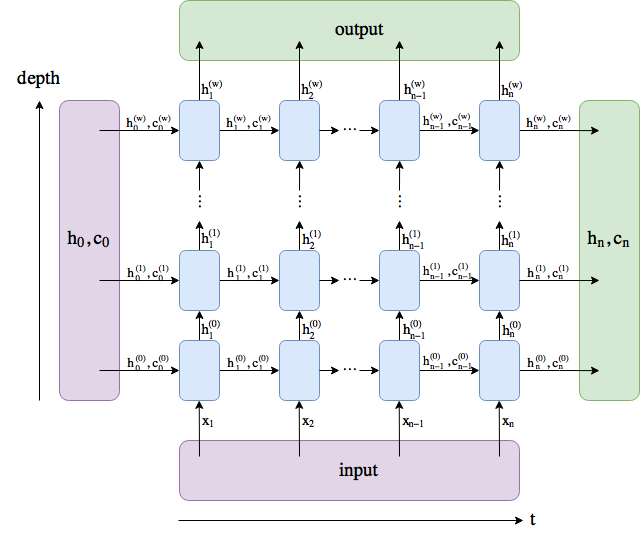

In [ ]:



print(train_x.shape)
# print(embedding_layer)
input = embedding_layer(train_x)
print(input.shape)
lstm = nn.LSTM(input_size = 250, hidden_size = 8, num_layers = 5, batch_first=True)
a = lstm(input)
print(a[0].shape)

print(a[0][0])
print(a[0][0].shape)

print(a[0][:,0,:].shape)

torch.Size([200000, 7])
torch.Size([200000, 7, 250])


In [13]:
from torch import nn
#  5 
x = torch.rand([5,4,3])
print(x)
x = nn.LSTM(, num_layers=2, batch_first=True)(x,None)
print(x)

tensor([[[0.3569, 0.6196, 0.0428],
         [0.2071, 0.3757, 0.6306],
         [0.2115, 0.1512, 0.8808],
         [0.8912, 0.1054, 0.2327]],

        [[0.9929, 0.6118, 0.0184],
         [0.4313, 0.3615, 0.8026],
         [0.4923, 0.0164, 0.8610],
         [0.5669, 0.3129, 0.5037]],

        [[0.8783, 0.2691, 0.9538],
         [0.9745, 0.1745, 0.1450],
         [0.0115, 0.6145, 0.7512],
         [0.4000, 0.8153, 0.1036]],

        [[0.3495, 0.1458, 0.3919],
         [0.5251, 0.3193, 0.9116],
         [0.7709, 0.2423, 0.6467],
         [0.9586, 0.7667, 0.3692]],

        [[0.1175, 0.8370, 0.9423],
         [0.8454, 0.3778, 0.0580],
         [0.9952, 0.6535, 0.5155],
         [0.2686, 0.0030, 0.5438]]])


TypeError: ignored

### Train

In [ ]:
# train.py
# 這個 block 是用來訓練模型的
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

def training(batch_size, n_epoch, lr, model_dir, train, valid, model, device):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('\nstart training, parameter total:{}, trainable:{}\n'.format(total, trainable))
    model.train() # 將 model 的模式設為 train，這樣 optimizer 就可以更新 model 的參數
    criterion = nn.BCELoss() # 定義損失函數，這裡我們使用 binary cross entropy loss
    t_batch = len(train) 
    v_batch = len(valid) 
    optimizer = optim.Adam(model.parameters(), lr=lr) # 將模型的參數給 optimizer，並給予適當的 learning rate
    total_loss, total_acc, best_acc = 0, 0, 0
    for epoch in range(n_epoch):
        total_loss, total_acc = 0, 0
        # 這段做 training
        for i, (inputs, labels) in enumerate(train):
            inputs = inputs.to(device, dtype=torch.long) # device 為 "cuda"，將 inputs 轉成 torch.cuda.LongTensor
            labels = labels.to(device, dtype=torch.float) # device為 "cuda"，將 labels 轉成 torch.cuda.FloatTensor，因為等等要餵進 criterion，所以型態要是 float
            optimizer.zero_grad() # 由於 loss.backward() 的 gradient 會累加，所以每次餵完一個 batch 後需要歸零
            outputs = model(inputs) # 將 input 餵給模型
            outputs = outputs.squeeze() # 去掉最外面的 dimension，好讓 outputs 可以餵進 criterion()
            loss = criterion(outputs, labels) # 計算此時模型的 training loss
            loss.backward() # 算 loss 的 gradient
            optimizer.step() # 更新訓練模型的參數
            correct = evaluation(outputs, labels) # 計算此時模型的 training accuracy
            total_acc += (correct / batch_size)
            total_loss += loss.item()
            print('[ Epoch{}: {}/{} ] loss:{:.3f} acc:{:.3f} '.format(
            	epoch+1, i+1, t_batch, loss.item(), correct*100/batch_size), end='\r')
        print('\nTrain | Loss:{:.5f} Acc: {:.3f}'.format(total_loss/t_batch, total_acc/t_batch*100))

        # 這段做 validation
        model.eval() # 將 model 的模式設為 eval，這樣 model 的參數就會固定住
        with torch.no_grad():
            total_loss, total_acc = 0, 0
            for i, (inputs, labels) in enumerate(valid):
                inputs = inputs.to(device, dtype=torch.long) # device 為 "cuda"，將 inputs 轉成 torch.cuda.LongTensor
                labels = labels.to(device, dtype=torch.float) # device 為 "cuda"，將 labels 轉成 torch.cuda.FloatTensor，因為等等要餵進 criterion，所以型態要是 float
                outputs = model(inputs) # 將 input 餵給模型
                outputs = outputs.squeeze() # 去掉最外面的 dimension，好讓 outputs 可以餵進 criterion()
                loss = criterion(outputs, labels) # 計算此時模型的 validation loss
                correct = evaluation(outputs, labels) # 計算此時模型的 validation accuracy
                total_acc += (correct / batch_size)
                total_loss += loss.item()

            print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss/v_batch, total_acc/v_batch*100))
            if total_acc > best_acc:
                # 如果 validation 的結果優於之前所有的結果，就把當下的模型存下來以備之後做預測時使用
                best_acc = total_acc
                #torch.save(model, "{}/val_acc_{:.3f}.model".format(model_dir,total_acc/v_batch*100))
                torch.save(model, "{}/ckpt.model".format(model_dir))
                print('saving model with acc {:.3f}'.format(total_acc/v_batch*100))
        print('-----------------------------------------------')
        model.train() # 將 model 的模式設為 train，這樣 optimizer 就可以更新 model 的參數（因為剛剛轉成 eval 模式）

### Test

In [ ]:
# test.py
# 這個 block 用來對 testing_data.txt 做預測
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

def testing(batch_size, test_loader, model, device):
    model.eval()
    ret_output = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            outputs[outputs>=0.5] = 1 # 大於等於 0.5 為正面
            outputs[outputs<0.5] = 0 # 小於 0.5 為負面
            ret_output += outputs.int().tolist()
    
    return ret_output

### Main

In [ ]:
# main.py
import os
import torch
import argparse
import numpy as np
from torch import nn
from gensim.models import word2vec
from sklearn.model_selection import train_test_split

# 通過 torch.cuda.is_available() 的回傳值進行判斷是否有使用 GPU 的環境，如果有的話 device 就設為 "cuda"，沒有的話就設為 "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 處理好各個 data 的路徑
train_with_label = os.path.join(path_prefix, 'training_label.txt')
train_no_label = os.path.join(path_prefix, 'training_nolabel.txt')
testing_data = os.path.join(path_prefix, 'testing_data.txt')

w2v_path = os.path.join(path_prefix, 'w2v_all.model') # 處理 word to vec model 的路徑

# 定義句子長度、要不要固定 embedding、batch 大小、要訓練幾個 epoch、learning rate 的值、model 的資料夾路徑
sen_len = 20
fix_embedding = True # fix embedding during training
batch_size = 128
epoch = 5
lr = 0.001
# model_dir = os.path.join(path_prefix, 'model/') # model directory for checkpoint model
model_dir = path_prefix # model directory for checkpoint model

print("loading data ...") # 把 'training_label.txt' 跟 'training_nolabel.txt' 讀進來
train_x, y = load_training_data(train_with_label)
train_x_no_label = load_training_data(train_no_label)

# 對 input 跟 labels 做預處理
preprocess = Preprocess(train_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
train_x = preprocess.sentence_word2idx()
y = preprocess.labels_to_tensor(y)

# 製作一個 model 的對象
model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=150, num_layers=1, dropout=0.5, fix_embedding=fix_embedding)
model = model.to(device) # device為 "cuda"，model 使用 GPU 來訓練（餵進去的 inputs 也需要是 cuda tensor）

# 把 data 分為 training data 跟 validation data（將一部份 training data 拿去當作 validation data）
X_train, X_val, y_train, y_val = train_x[:180000], train_x[180000:], y[:180000], y[180000:]

# 把 data 做成 dataset 供 dataloader 取用
train_dataset = TwitterDataset(X=X_train, y=y_train)
val_dataset = TwitterDataset(X=X_val, y=y_val)

# 把 data 轉成 batch of tensors
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 8)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)

# 開始訓練
training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device)

### Predict and Write to csv file

In [ ]:
# 開始測試模型並做預測
print("loading testing data ...")
test_x = load_testing_data(testing_data)
preprocess = Preprocess(test_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
test_x = preprocess.sentence_word2idx()
test_dataset = TwitterDataset(X=test_x, y=None)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)
print('\nload model ...')
model = torch.load(os.path.join(model_dir, 'ckpt.model'))
outputs = testing(batch_size, test_loader, model, device)

# 寫到 csv 檔案供上傳 Kaggle
tmp = pd.DataFrame({"id":[str(i) for i in range(len(test_x))],"label":outputs})
print("save csv ...")
tmp.to_csv(os.path.join(path_prefix, 'predict.csv'), index=False)
print("Finish Predicting")

# 以下是使用 command line 上傳到 Kaggle 的方式
# 需要先 pip install kaggle、Create API Token，詳細請看 https://github.com/Kaggle/kaggle-api 以及 https://www.kaggle.com/code1110/how-to-submit-from-google-colab
# kaggle competitions submit [competition-name] -f [csv file path]] -m [message]
# e.g., kaggle competitions submit ml-2020spring-hw4 -f output/predict.csv -m "......"

#### Check where the files are

In [ ]:
!pwd
!ls

#### Download the files to your computer

In [ ]:
from google.colab import files
files.download('predict.csv')